## March Madness 2024 Bracket Predictive Model

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

#### Create Training Data

In [2]:
team_data = pd.read_csv('./MTeams.csv') # all team data
results_data = pd.read_csv('./MNCAATourneyDetailedResults.csv') # data from every march madness game from 2008
name_results_df = pd.merge(left=results_data, right=team_data, left_on='WTeamID', right_on='TeamID') 
name_results_df = pd.merge(left=name_results_df, right=team_data, left_on='LTeamID', right_on='TeamID')
name_results_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LBlk,LPF,TeamID_x,TeamName_x,FirstD1Season_x,LastD1Season_x,TeamID_y,TeamName_y,FirstD1Season_y,LastD1Season_y
0,2003,134,1421,92,1411,84,N,1,32,69,...,0,22,1421,UNC Asheville,1987,2024,1411,TX Southern,1985,2024
1,2015,136,1112,93,1411,72,N,0,32,53,...,3,19,1112,Arizona,1985,2024,1411,TX Southern,1985,2024
2,2022,136,1242,83,1411,56,N,0,34,68,...,6,14,1242,Kansas,1985,2024,1411,TX Southern,1985,2024
3,2018,137,1462,102,1411,83,N,0,35,64,...,3,21,1462,Xavier,1985,2024,1411,TX Southern,1985,2024
4,2017,137,1314,103,1411,64,N,0,38,75,...,3,17,1314,North Carolina,1985,2024,1411,TX Southern,1985,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2021,136,1313,54,1111,53,N,0,20,58,...,10,8,1313,Norfolk St,1998,2024,1111,Appalachian St,1985,2024
1311,2015,135,1352,81,1316,77,N,0,28,62,...,4,23,1352,Robert Morris,1985,2024,1316,North Florida,2006,2024
1312,2019,134,1192,82,1341,76,N,0,30,55,...,1,19,1192,F Dickinson,1985,2024,1341,Prairie View,1985,2024
1313,2022,135,1460,93,1136,82,N,0,29,61,...,5,24,1460,Wright St,1988,2024,1136,Bryant,2009,2024


In [3]:
# simplify dataset to all match ups and the winning/losing team
games_df = name_results_df[['Season', 'TeamName_x', 'TeamName_y']]
games_df = games_df.rename(columns={'TeamName_x': 'WinningTeam', 'TeamName_y': 'LosingTeam'})
games_df['Win'] = 1
games_df

,Season,WinningTeam,LosingTeam,Win
0,2003,UNC Asheville,TX Southern,1
1,2015,Arizona,TX Southern,1
2,2022,Kansas,TX Southern,1
3,2018,Xavier,TX Southern,1
4,2017,North Carolina,TX Southern,1
...,...,...,...,...
1310,2021,Norfolk St,Appalachian St,1
1311,2015,Robert Morris,North Florida,1
1312,2019,F Dickinson,Prairie View,1
1313,2022,Wright St,Bryant,1


In [4]:
# team statistics for each march madness team since 2008
all_data = pd.read_csv('./KenPom Barttorvik.csv')
cols_to_include = ['YEAR', 'CONF', 'TEAM', 'SEED', 'KADJ T', 'KADJ O', \
                   'KADJ D', 'KADJ EM', 'WIN%', 'EFG%', 'EFG%D', 'FTR', \
                    'TOV%', 'TOV%D', 'OREB%', 'DREB%', '2PT%', '3PT%', \
                        'BLKED%', 'AST%', 'TALENT']
all_data = all_data[cols_to_include]
all_data

,YEAR,CONF,TEAM,SEED,KADJ T,KADJ O,KADJ D,KADJ EM,WIN%,EFG%,...,FTR,TOV%,TOV%D,OREB%,DREB%,2PT%,3PT%,BLKED%,AST%,TALENT
0,2024,MAC,Akron,14,65.8933,107.0090,102.0720,4.93709,68.750000,52.0,...,33.6,17.2,16.6,29.5,74.4,54.8,32.0,7.8,48.2,10.970
1,2024,SEC,Alabama,4,72.6461,125.6010,103.1180,22.48280,65.625000,56.3,...,35.2,16.0,15.6,34.9,70.1,57.6,36.5,12.5,51.5,27.836
2,2024,P12,Arizona,2,71.8379,121.1250,94.5013,26.62370,75.757576,55.0,...,36.7,16.1,18.1,36.3,76.9,54.6,37.1,8.6,59.1,76.342
3,2024,SEC,Auburn,4,69.7887,120.5790,91.6765,28.90260,79.411765,54.1,...,38.2,14.9,18.2,32.9,69.7,54.9,35.2,8.6,62.0,43.053
4,2024,B12,Baylor,3,65.6032,122.4900,100.1850,22.30500,68.750000,55.6,...,40.5,17.7,17.1,35.1,72.9,53.4,39.4,9.8,53.9,58.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,2008,BE,West Virginia,7,63.0942,113.5700,93.4302,20.14000,69.696970,51.6,...,37.1,16.3,23.3,34.1,68.6,50.6,35.8,6.7,58.6,46.742
1075,2008,SB,Western Kentucky,12,66.5432,111.0760,97.0110,14.06460,80.645160,53.6,...,36.2,20.2,25.2,37.0,67.2,51.6,38.6,6.6,46.0,16.148
1076,2008,BSth,Winthrop,13,60.9746,99.6932,92.3864,7.30673,64.516130,50.0,...,36.3,20.0,23.4,33.8,71.0,47.1,37.4,7.1,54.7,4.133
1077,2008,B10,Wisconsin,3,60.8809,113.6190,86.2081,27.41070,87.878790,50.6,...,39.3,19.4,22.2,36.2,71.5,49.2,35.9,8.5,54.6,82.100


In [5]:
# put together all the march madness games from 2008 to include matchups and statistics
training_data = pd.DataFrame()
for year in range(2008, 2024):
    games_for_year = games_df[games_df['Season'] == year]
    all_data_for_year = all_data[all_data['YEAR'] == year]
    rows_to_swap = games_for_year.sample(frac=0.5)  # Adjust fraction as needed
    # Swap WinningTeam and LosingTeam for selected rows
    games_for_year.loc[rows_to_swap.index, ['WinningTeam', 'LosingTeam']] = games_for_year.loc[rows_to_swap.index, ['LosingTeam', 'WinningTeam']].values

    # Update the Win column for the swapped rows to 0
    games_for_year.loc[rows_to_swap.index, 'Win'] = 0
    games_for_year = games_for_year.rename(columns={'WinningTeam': 'Team1', 'LosingTeam' : 'Team2'})
    merged_for_year = pd.merge(left=games_for_year, right=all_data_for_year, left_on='Team1', right_on='TEAM', how='left')
    merged_for_year = pd.merge(left=merged_for_year, right=all_data_for_year, left_on='Team2', right_on='TEAM', how='left')
    merged_for_year = merged_for_year.dropna().reset_index(drop=True)
    
    training_data = pd.concat([training_data, merged_for_year], axis=0)

# save training data
training_data.to_csv('./march-madness-training-data.csv')
training_data

,Season,Team1,Team2,Win,YEAR_x,CONF_x,TEAM_x,SEED_x,KADJ T_x,KADJ O_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,2008,Gonzaga,Davidson,0,2008.0,WCC,Gonzaga,7.0,65.1856,114.221,...,25.4,17.7,24.1,32.6,72.4,54.6,36.1,6.7,58.6,18.502
1,2008,Davidson,Wisconsin,1,2008.0,SC,Davidson,10.0,66.0806,114.056,...,39.3,19.4,22.2,36.2,71.5,49.2,35.9,8.5,54.6,82.100
2,2008,Kansas,Memphis,1,2008.0,B12,Kansas,1.0,66.8546,121.433,...,38.6,17.2,23.3,37.8,70.7,53.3,35.0,8.2,55.7,82.995
3,2008,Memphis,Texas,1,2008.0,CUSA,Memphis,1.0,67.7113,114.695,...,32.6,14.1,18.5,36.1,66.3,48.7,37.7,7.3,47.2,81.767
4,2008,Duke,West Virginia,0,2008.0,ACC,Duke,2.0,70.9709,117.443,...,37.1,16.3,23.3,34.1,68.6,50.6,35.8,6.7,58.6,46.742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,2023,Virginia,Furman,0,2023.0,ACC,Virginia,4.0,61.5696,111.166,...,34.7,15.8,18.4,29.6,72.9,59.1,34.4,8.2,58.5,4.159
29,2023,Miami FL,Houston,1,2023.0,ACC,Miami FL,5.0,68.8527,118.233,...,28.5,15.3,22.0,37.1,72.6,53.2,34.5,6.6,53.8,68.424
30,2023,UCLA,UNC Asheville,1,2023.0,P12,UCLA,2.0,66.2741,114.875,...,41.3,20.0,17.9,25.8,71.3,51.4,38.8,11.2,50.1,10.661
31,2023,Auburn,Houston,0,2023.0,SEC,Auburn,9.0,67.6112,112.689,...,28.5,15.3,22.0,37.1,72.6,53.2,34.5,6.6,53.8,68.424


In [8]:
training_data = pd.read_csv('./march-madness-training-data.csv')
# drop categorical columns
cat_cols = [col for col in training_data.columns if training_data[col].dtype == 'object']
training_data = training_data.drop(cat_cols, axis=1)
# drop columns not relevant to team stats
season_cols = ['Season', 'YEAR_x', 'YEAR_y']
training_data = training_data.drop(season_cols, axis=1)
training_data

,Win,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,1,10.0,66.0806,114.056,93.5027,20.55320,80.64516,54.4,48.4,25.4,...,40.2,20.5,21.7,34.5,70.4,53.6,37.2,9.2,53.8,73.800
1,0,3.0,60.8809,113.619,86.2081,27.41070,87.87879,50.6,43.1,39.3,...,25.4,17.7,24.1,32.6,72.4,54.6,36.1,6.7,58.6,18.502
2,0,1.0,67.7113,114.695,85.3169,29.37790,97.05882,53.0,42.5,38.6,...,37.5,18.7,22.9,38.0,71.0,54.8,39.9,6.5,62.8,89.633
3,0,2.0,63.0818,119.757,94.9061,24.85130,81.81818,51.4,46.1,32.6,...,38.6,17.2,23.3,37.8,70.7,53.3,35.0,8.2,55.7,82.995
4,0,2.0,70.9709,117.443,89.8149,27.62850,84.37500,54.1,47.6,40.4,...,37.1,16.3,23.3,34.1,68.6,50.6,35.8,6.7,58.6,46.742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,0,4.0,61.5696,111.166,94.7544,16.41140,78.12500,51.3,48.3,34.5,...,34.7,15.8,18.4,29.6,72.9,59.1,34.4,8.2,58.5,4.159
579,1,5.0,68.8527,118.233,103.3190,14.91480,78.12500,55.0,51.3,30.0,...,28.5,15.3,22.0,37.1,72.6,53.2,34.5,6.6,53.8,68.424
580,0,15.0,68.5066,104.141,102.6350,1.50642,78.12500,53.9,48.0,41.3,...,27.1,15.3,23.6,33.7,72.4,50.4,34.7,6.3,50.9,83.585
581,0,9.0,67.6112,112.689,95.2408,17.44840,62.50000,49.6,45.6,35.5,...,28.5,15.3,22.0,37.1,72.6,53.2,34.5,6.6,53.8,68.424


#### Build Model

In [7]:
X = training_data.copy()
y = X.pop('Win')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75)

In [10]:
input_shape = [X_train.shape[1]]

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),

    layers.Dense(units=256),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(units=1),
    layers.Activation('sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=60,
)

Epoch 1/60
7/7 [==============================] - 1s 52ms/step - loss: 0.6759 - binary_accuracy: 0.5767 - val_loss: 1.7191 - val_binary_accuracy: 0.5205
Epoch 2/60
7/7 [==============================] - 0s 11ms/step - loss: 0.5855 - binary_accuracy: 0.6819 - val_loss: 0.8853 - val_binary_accuracy: 0.6781
Epoch 3/60
7/7 [==============================] - 0s 11ms/step - loss: 0.5417 - binary_accuracy: 0.7162 - val_loss: 0.6772 - val_binary_accuracy: 0.6438
Epoch 4/60
7/7 [==============================] - 0s 11ms/step - loss: 0.5261 - binary_accuracy: 0.7300 - val_loss: 0.6979 - val_binary_accuracy: 0.6918
Epoch 5/60
7/7 [==============================] - 0s 11ms/step - loss: 0.5178 - binary_accuracy: 0.7506 - val_loss: 0.6750 - val_binary_accuracy: 0.7055
Epoch 6/60
7/7 [==============================] - 0s 11ms/step - loss: 0.4937 - binary_accuracy: 0.7643 - val_loss: 0.7198 - val_binary_accuracy: 0.6849
Epoch 7/60
7/7 [==============================] - 0s 11ms/step - loss: 0.5023 - bi

#### Test model

5/5 [==============================] - 0s 2ms/step
[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Accuracy: 0.6643835616438356
Recall: 0.6463414634146342
F1 Score: 0.6838709677419356


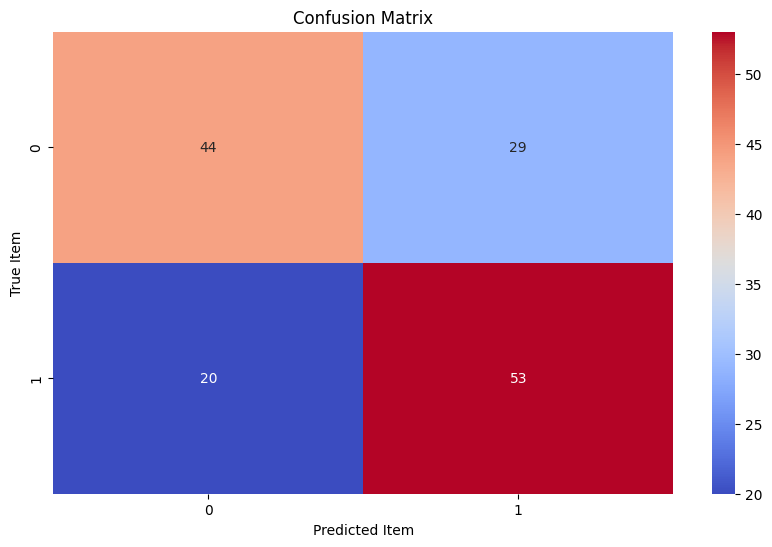

In [11]:
preds = model.predict(X_valid)
preds = [0 if (x<0.5) else 1 for x in preds]
print(preds)
print(f'Accuracy: {metrics.accuracy_score(preds, y_valid)}')
print(f'Recall: {metrics.recall_score(preds, y_valid)}')
print(f'F1 Score: {metrics.f1_score(preds, y_valid)}')
# confusion matrix
cm = metrics.confusion_matrix(y_valid, preds)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm').set\
    (title='Confusion Matrix',
    xlabel='Predicted Item', ylabel='True Item')
plt.show()

#### Create Testing Data for 2024 Tournament

In [5]:
games_2024 = pd.read_csv('./firstround2024 - Sheet1.csv')
games_2024 = games_2024.rename(columns={'2024': 'Year'})
games_2024

,Year,Team1,Team2
0,2024,Akron,Creighton
1,2024,Alabama,College of Charleston
2,2024,Arizona,Long Beach St.
3,2024,Auburn,Yale
4,2024,Baylor,Colgate
5,2024,BYU,Duquesne
6,2024,Clemson,New Mexico
7,2024,Colorado,Florida
8,2024,Colorado St.,Texas
9,2024,Connecticut,Stetson


In [6]:
all_data_2024 = all_data[all_data['YEAR'] == 2024]
merged_2024 = pd.merge(left=games_2024, right=all_data_2024, left_on='Team1', right_on='TEAM', how='left')
merged_2024 = pd.merge(left=merged_2024, right=all_data_2024, left_on='Team2', right_on='TEAM', how='left')
merged_2024

,Year,Team1,Team2,YEAR_x,CONF_x,TEAM_x,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,2024,Akron,Creighton,2024,MAC,Akron,14,65.8933,107.0090,102.0720,...,24.5,15.3,11.2,25.9,75.4,60.6,36.1,9.1,58.6,52.884
1,2024,Alabama,College of Charleston,2024,SEC,Alabama,4,72.6461,125.6010,103.1180,...,26.9,14.3,16.4,33.5,73.4,52.6,34.8,10.0,53.6,5.524
2,2024,Arizona,Long Beach St.,2024,P12,Arizona,2,71.8379,121.1250,94.5013,...,38.1,17.1,18.5,33.3,70.4,49.7,31.3,5.9,55.1,11.174
3,2024,Auburn,Yale,2024,SEC,Auburn,4,69.7887,120.5790,91.6765,...,26.9,14.1,16.0,28.4,76.0,52.5,34.6,8.6,53.3,9.096
4,2024,Baylor,Colgate,2024,B12,Baylor,3,65.6032,122.4900,100.1850,...,27.6,16.3,16.1,25.0,75.5,53.3,35.7,7.3,56.6,0.200
5,2024,BYU,Duquesne,2024,B12,BYU,6,69.0581,120.4860,99.4765,...,33.1,17.5,19.5,29.9,70.0,49.6,33.9,11.4,53.8,0.200
6,2024,Clemson,New Mexico,2024,ACC,Clemson,6,66.1056,117.4260,100.4890,...,33.1,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824
7,2024,Colorado,Florida,2024,P12,Colorado,10,67.5085,117.5790,99.1127,...,38.6,15.8,14.5,37.5,71.1,51.7,34.2,9.6,50.2,30.164
8,2024,Colorado St.,Texas,2024,MWC,Colorado St.,10,65.8043,115.3820,98.7790,...,30.4,16.6,18.6,30.5,70.0,53.4,36.1,9.0,56.5,50.353
9,2024,Connecticut,Stetson,2024,BE,Connecticut,1,64.4543,126.6080,94.3949,...,31.7,15.8,13.5,27.5,68.8,52.5,36.5,8.1,48.7,19.778


In [10]:
testing_data = merged_2024.drop(cat_cols, axis=1)
season_cols2 = ['Year', 'YEAR_x', 'YEAR_y']
testing_data = testing_data.drop(season_cols2, axis=1)
# save testing data
testing_data.to_csv('./march-madness-testing-data.csv')
testing_data

,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,14,65.8933,107.0090,102.0720,4.93709,68.750000,52.0,48.6,33.6,17.2,...,24.5,15.3,11.2,25.9,75.4,60.6,36.1,9.1,58.6,52.884
1,4,72.6461,125.6010,103.1180,22.48280,65.625000,56.3,49.9,35.2,16.0,...,26.9,14.3,16.4,33.5,73.4,52.6,34.8,10.0,53.6,5.524
2,2,71.8379,121.1250,94.5013,26.62370,75.757576,55.0,48.7,36.7,16.1,...,38.1,17.1,18.5,33.3,70.4,49.7,31.3,5.9,55.1,11.174
3,4,69.7887,120.5790,91.6765,28.90260,79.411765,54.1,43.4,38.2,14.9,...,26.9,14.1,16.0,28.4,76.0,52.5,34.6,8.6,53.3,9.096
4,3,65.6032,122.4900,100.1850,22.30500,68.750000,55.6,51.3,40.5,17.7,...,27.6,16.3,16.1,25.0,75.5,53.3,35.7,7.3,56.6,0.200
5,6,69.0581,120.4860,99.4765,21.00910,69.696970,55.1,48.0,25.3,15.2,...,33.1,17.5,19.5,29.9,70.0,49.6,33.9,11.4,53.8,0.200
6,6,66.1056,117.4260,100.4890,16.93710,65.625000,53.9,48.7,30.6,14.9,...,33.1,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824
7,10,67.5085,117.5790,99.1127,18.46660,70.588235,55.3,49.3,35.3,18.1,...,38.6,15.8,14.5,37.5,71.1,51.7,34.2,9.6,50.2,30.164
8,10,65.8043,115.3820,98.7790,16.60270,68.750000,54.6,49.3,32.6,14.8,...,30.4,16.6,18.6,30.5,70.0,53.4,36.1,9.0,56.5,50.353
9,1,64.4543,126.6080,94.3949,32.21300,91.176471,57.1,45.1,33.3,14.9,...,31.7,15.8,13.5,27.5,68.8,52.5,36.5,8.1,48.7,19.778


#### Make predictions with model

In [15]:
testing_data = pd.read_csv('./march-madness-testing-data.csv')
# first round
first_round_preds = model.predict(testing_data)
first_round_preds = [0 if (x<0.5) else 1 for x in first_round_preds]
testing_data_with_preds = testing_data.copy()
testing_data_with_preds['Win'] = first_round_preds
testing_data_with_preds

1/1 [==============================] - 0s 32ms/step


,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y,Win
0,14,65.8933,107.0090,102.0720,4.93709,68.750000,52.0,48.6,33.6,17.2,...,15.3,11.2,25.9,75.4,60.6,36.1,9.1,58.6,52.884,0
1,4,72.6461,125.6010,103.1180,22.48280,65.625000,56.3,49.9,35.2,16.0,...,14.3,16.4,33.5,73.4,52.6,34.8,10.0,53.6,5.524,1
2,2,71.8379,121.1250,94.5013,26.62370,75.757576,55.0,48.7,36.7,16.1,...,17.1,18.5,33.3,70.4,49.7,31.3,5.9,55.1,11.174,1
3,4,69.7887,120.5790,91.6765,28.90260,79.411765,54.1,43.4,38.2,14.9,...,14.1,16.0,28.4,76.0,52.5,34.6,8.6,53.3,9.096,1
4,3,65.6032,122.4900,100.1850,22.30500,68.750000,55.6,51.3,40.5,17.7,...,16.3,16.1,25.0,75.5,53.3,35.7,7.3,56.6,0.200,1
5,6,69.0581,120.4860,99.4765,21.00910,69.696970,55.1,48.0,25.3,15.2,...,17.5,19.5,29.9,70.0,49.6,33.9,11.4,53.8,0.200,1
6,6,66.1056,117.4260,100.4890,16.93710,65.625000,53.9,48.7,30.6,14.9,...,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824,0
7,10,67.5085,117.5790,99.1127,18.46660,70.588235,55.3,49.3,35.3,18.1,...,15.8,14.5,37.5,71.1,51.7,34.2,9.6,50.2,30.164,1
8,10,65.8043,115.3820,98.7790,16.60270,68.750000,54.6,49.3,32.6,14.8,...,16.6,18.6,30.5,70.0,53.4,36.1,9.0,56.5,50.353,0
9,1,64.4543,126.6080,94.3949,32.21300,91.176471,57.1,45.1,33.3,14.9,...,15.8,13.5,27.5,68.8,52.5,36.5,8.1,48.7,19.778,1


In [499]:
testing_data_with_preds.to_csv('./firstround-predictions.csv', index=False)

Manually created a new dataset which contains the winners from the first round and how they would be matched up in the second round.
Example of this file is seen in the block below.

In [16]:
secondround_games_2024 = pd.read_csv('./secondround2024 - Sheet1.csv')
secondround_games_2024

,Year,Team1,Team2
0,2024,Alabama,Saint Mary's
1,2024,Arizona,Dayton
2,2024,Auburn,San Diego St.
3,2024,Baylor,New Mexico
4,2024,BYU,Illinois
5,2024,Duke,Wisconsin
6,2024,Gonzaga,Kansas
7,2024,Houston,Texas A&M
8,2024,Iowa St.,Washington St.
9,2024,Kentucky,Texas Tech


In [502]:
secondround_merged_2024 = pd.merge(left=secondround_games_2024, right=all_data_2024, left_on='Team1', right_on='TEAM', how='left')
secondround_merged_2024 = pd.merge(left=secondround_merged_2024, right=all_data_2024, left_on='Team2', right_on='TEAM', how='left')
secondround_merged_2024

,Year,Team1,Team2,YEAR_x,CONF_x,TEAM_x,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,2024,Alabama,Saint Mary's,2024,SEC,Alabama,4,72.6461,125.601,103.1180,...,28.3,16.0,16.7,39.0,77.6,53.0,35.5,7.4,58.3,38.712
1,2024,Arizona,Dayton,2024,P12,Arizona,2,71.8379,121.125,94.5013,...,37.2,15.8,15.7,26.9,71.0,53.7,40.2,10.0,58.3,32.899
2,2024,Auburn,San Diego St.,2024,SEC,Auburn,4,69.7887,120.579,91.6765,...,37.5,16.0,18.0,32.7,72.0,51.6,31.3,8.9,50.8,43.201
3,2024,Baylor,New Mexico,2024,B12,Baylor,3,65.6032,122.490,100.1850,...,33.1,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824
4,2024,BYU,Illinois,2024,B12,BYU,6,69.0581,120.486,99.4765,...,37.8,15.1,12.3,36.2,73.9,54.7,34.9,8.3,44.4,56.834
5,2024,Duke,Wisconsin,2024,ACC,Duke,4,66.6784,121.827,96.9502,...,33.5,14.6,16.9,30.5,75.5,52.6,34.8,10.7,47.7,52.194
6,2024,Gonzaga,Kansas,2024,WCC,Gonzaga,5,69.0926,120.997,99.4329,...,32.8,16.4,16.8,25.3,73.6,54.8,33.3,7.0,66.5,64.218
7,2024,Houston,Texas A&M,2024,B12,Houston,1,63.2681,118.868,87.1492,...,38.2,14.2,16.9,41.9,72.0,47.0,28.4,13.6,44.5,55.263
8,2024,Iowa St.,Washington St.,2024,B12,Iowa St.,2,67.3399,113.864,87.1458,...,31.7,16.1,15.9,32.9,75.1,52.6,34.0,6.6,45.7,30.424
9,2024,Kentucky,Texas Tech,2024,SEC,Kentucky,3,72.6360,122.742,102.7240,...,34.6,16.5,17.0,30.2,69.7,51.5,36.5,10.1,55.9,50.406


In [503]:
secondround_testing_data = secondround_merged_2024.drop(cat_cols, axis=1)
secondround_testing_data = secondround_testing_data.drop(season_cols2, axis=1)
secondround_testing_data

,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,4,72.6461,125.601,103.1180,22.4828,65.625000,56.3,49.9,35.2,16.0,...,28.3,16.0,16.7,39.0,77.6,53.0,35.5,7.4,58.3,38.712
1,2,71.8379,121.125,94.5013,26.6237,75.757576,55.0,48.7,36.7,16.1,...,37.2,15.8,15.7,26.9,71.0,53.7,40.2,10.0,58.3,32.899
2,4,69.7887,120.579,91.6765,28.9026,79.411765,54.1,43.4,38.2,14.9,...,37.5,16.0,18.0,32.7,72.0,51.6,31.3,8.9,50.8,43.201
3,3,65.6032,122.490,100.1850,22.3050,68.750000,55.6,51.3,40.5,17.7,...,33.1,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824
4,6,69.0581,120.486,99.4765,21.0091,69.696970,55.1,48.0,25.3,15.2,...,37.8,15.1,12.3,36.2,73.9,54.7,34.9,8.3,44.4,56.834
5,4,66.6784,121.827,96.9502,24.8767,75.000000,55.2,49.0,33.8,14.3,...,33.5,14.6,16.9,30.5,75.5,52.6,34.8,10.7,47.7,52.194
6,5,69.0926,120.997,99.4329,21.5641,77.419355,56.7,47.3,31.5,14.0,...,32.8,16.4,16.8,25.3,73.6,54.8,33.3,7.0,66.5,64.218
7,1,63.2681,118.868,87.1492,31.7188,88.235294,49.7,44.0,29.9,13.7,...,38.2,14.2,16.9,41.9,72.0,47.0,28.4,13.6,44.5,55.263
8,2,67.3399,113.864,87.1458,26.7178,79.411765,51.9,47.1,36.1,15.7,...,31.7,16.1,15.9,32.9,75.1,52.6,34.0,6.6,45.7,30.424
9,3,72.6360,122.742,102.7240,20.0180,71.875000,57.4,49.5,30.4,14.2,...,34.6,16.5,17.0,30.2,69.7,51.5,36.5,10.1,55.9,50.406


In [505]:
second_round_preds = model.predict(secondround_testing_data)
second_round_preds = [0 if (x<0.5) else 1 for x in second_round_preds]
secondround_testing_data_with_preds = secondround_testing_data.copy()
secondround_testing_data_with_preds['Win'] = second_round_preds
secondround_testing_data_with_preds

1/1 [==============================] - 0s 21ms/step


,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y,Win
0,4,72.6461,125.601,103.1180,22.4828,65.625000,56.3,49.9,35.2,16.0,...,16.0,16.7,39.0,77.6,53.0,35.5,7.4,58.3,38.712,1
1,2,71.8379,121.125,94.5013,26.6237,75.757576,55.0,48.7,36.7,16.1,...,15.8,15.7,26.9,71.0,53.7,40.2,10.0,58.3,32.899,1
2,4,69.7887,120.579,91.6765,28.9026,79.411765,54.1,43.4,38.2,14.9,...,16.0,18.0,32.7,72.0,51.6,31.3,8.9,50.8,43.201,0
3,3,65.6032,122.490,100.1850,22.3050,68.750000,55.6,51.3,40.5,17.7,...,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824,0
4,6,69.0581,120.486,99.4765,21.0091,69.696970,55.1,48.0,25.3,15.2,...,15.1,12.3,36.2,73.9,54.7,34.9,8.3,44.4,56.834,0
5,4,66.6784,121.827,96.9502,24.8767,75.000000,55.2,49.0,33.8,14.3,...,14.6,16.9,30.5,75.5,52.6,34.8,10.7,47.7,52.194,1
6,5,69.0926,120.997,99.4329,21.5641,77.419355,56.7,47.3,31.5,14.0,...,16.4,16.8,25.3,73.6,54.8,33.3,7.0,66.5,64.218,1
7,1,63.2681,118.868,87.1492,31.7188,88.235294,49.7,44.0,29.9,13.7,...,14.2,16.9,41.9,72.0,47.0,28.4,13.6,44.5,55.263,1
8,2,67.3399,113.864,87.1458,26.7178,79.411765,51.9,47.1,36.1,15.7,...,16.1,15.9,32.9,75.1,52.6,34.0,6.6,45.7,30.424,1
9,3,72.6360,122.742,102.7240,20.0180,71.875000,57.4,49.5,30.4,14.2,...,16.5,17.0,30.2,69.7,51.5,36.5,10.1,55.9,50.406,1


In [506]:
secondround_testing_data_with_preds.to_csv('./secondround-predictions.csv', index=False)

In [507]:
thirdround_games_2024 = pd.read_csv('./thirdround2024 - Sheet1.csv')
thirdround_games_2024

,Year,Team1,Team2
0,2024,Alabama,North Carolina
1,2024,Arizona,New Mexico
2,2024,Duke,Houston
3,2024,Gonzaga,TCU
4,2024,Iowa St.,Illinois
5,2024,Kentucky,Marquette
6,2024,Connecticut,San Diego St.
7,2024,Creighton,Tennessee


In [508]:
thirdround_merged_2024 = pd.merge(left=thirdround_games_2024, right=all_data_2024, left_on='Team1', right_on='TEAM', how='left')
thirdround_merged_2024 = pd.merge(left=thirdround_merged_2024, right=all_data_2024, left_on='Team2', right_on='TEAM', how='left')
thirdround_merged_2024

,Year,Team1,Team2,YEAR_x,CONF_x,TEAM_x,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,2024,Alabama,North Carolina,2024,SEC,Alabama,4,72.6461,125.601,103.1180,...,36.8,14.4,14.9,32.8,76.5,50.3,35.4,9.6,51.5,88.407
1,2024,Arizona,New Mexico,2024,P12,Arizona,2,71.8379,121.125,94.5013,...,33.1,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824
2,2024,Duke,Houston,2024,ACC,Duke,4,66.6784,121.827,96.9502,...,29.9,13.7,24.7,36.9,69.8,48.4,34.7,7.4,49.1,63.543
3,2024,Gonzaga,TCU,2024,WCC,Gonzaga,5,69.0926,120.997,99.4329,...,35.1,17.9,20.8,35.5,71.4,51.2,35.6,8.7,59.5,53.769
4,2024,Iowa St.,Illinois,2024,B12,Iowa St.,2,67.3399,113.864,87.1458,...,37.8,15.1,12.3,36.2,73.9,54.7,34.9,8.3,44.4,56.834
5,2024,Kentucky,Marquette,2024,SEC,Kentucky,3,72.6360,122.742,102.7240,...,25.6,14.3,21.1,26.0,69.2,56.0,35.8,8.4,54.3,57.136
6,2024,Connecticut,San Diego St.,2024,BE,Connecticut,1,64.4543,126.608,94.3949,...,37.5,16.0,18.0,32.7,72.0,51.6,31.3,8.9,50.8,43.201
7,2024,Creighton,Tennessee,2024,BE,Creighton,3,67.0297,120.091,96.6912,...,34.3,14.6,18.9,32.4,71.4,51.6,34.2,8.0,61.2,55.338


In [509]:
thirdround_testing_data = thirdround_merged_2024.drop(cat_cols, axis=1)
thirdround_testing_data = thirdround_testing_data.drop(season_cols2, axis=1)
thirdround_testing_data

,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,4,72.6461,125.601,103.1180,22.4828,65.625000,56.3,49.9,35.2,16.0,...,36.8,14.4,14.9,32.8,76.5,50.3,35.4,9.6,51.5,88.407
1,2,71.8379,121.125,94.5013,26.6237,75.757576,55.0,48.7,36.7,16.1,...,33.1,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824
2,4,66.6784,121.827,96.9502,24.8767,75.000000,55.2,49.0,33.8,14.3,...,29.9,13.7,24.7,36.9,69.8,48.4,34.7,7.4,49.1,63.543
3,5,69.0926,120.997,99.4329,21.5641,77.419355,56.7,47.3,31.5,14.0,...,35.1,17.9,20.8,35.5,71.4,51.2,35.6,8.7,59.5,53.769
4,2,67.3399,113.864,87.1458,26.7178,79.411765,51.9,47.1,36.1,15.7,...,37.8,15.1,12.3,36.2,73.9,54.7,34.9,8.3,44.4,56.834
5,3,72.6360,122.742,102.7240,20.0180,71.875000,57.4,49.5,30.4,14.2,...,25.6,14.3,21.1,26.0,69.2,56.0,35.8,8.4,54.3,57.136
6,1,64.4543,126.608,94.3949,32.2130,91.176471,57.1,45.1,33.3,14.9,...,37.5,16.0,18.0,32.7,72.0,51.6,31.3,8.9,50.8,43.201
7,3,67.0297,120.091,96.6912,23.3993,71.875000,57.5,46.4,24.5,15.3,...,34.3,14.6,18.9,32.4,71.4,51.6,34.2,8.0,61.2,55.338


In [510]:
third_round_preds = model.predict(thirdround_testing_data)
third_round_preds = [0 if (x<0.5) else 1 for x in third_round_preds]
thirdround_testing_data_with_preds = thirdround_testing_data.copy()
thirdround_testing_data_with_preds['Win'] = third_round_preds
thirdround_testing_data_with_preds

1/1 [==============================] - 0s 25ms/step


,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y,Win
0,4,72.6461,125.601,103.1180,22.4828,65.625000,56.3,49.9,35.2,16.0,...,14.4,14.9,32.8,76.5,50.3,35.4,9.6,51.5,88.407,0
1,2,71.8379,121.125,94.5013,26.6237,75.757576,55.0,48.7,36.7,16.1,...,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824,0
2,4,66.6784,121.827,96.9502,24.8767,75.000000,55.2,49.0,33.8,14.3,...,13.7,24.7,36.9,69.8,48.4,34.7,7.4,49.1,63.543,1
3,5,69.0926,120.997,99.4329,21.5641,77.419355,56.7,47.3,31.5,14.0,...,17.9,20.8,35.5,71.4,51.2,35.6,8.7,59.5,53.769,1
4,2,67.3399,113.864,87.1458,26.7178,79.411765,51.9,47.1,36.1,15.7,...,15.1,12.3,36.2,73.9,54.7,34.9,8.3,44.4,56.834,1
5,3,72.6360,122.742,102.7240,20.0180,71.875000,57.4,49.5,30.4,14.2,...,14.3,21.1,26.0,69.2,56.0,35.8,8.4,54.3,57.136,1
6,1,64.4543,126.608,94.3949,32.2130,91.176471,57.1,45.1,33.3,14.9,...,16.0,18.0,32.7,72.0,51.6,31.3,8.9,50.8,43.201,1
7,3,67.0297,120.091,96.6912,23.3993,71.875000,57.5,46.4,24.5,15.3,...,14.6,18.9,32.4,71.4,51.6,34.2,8.0,61.2,55.338,1


In [513]:
fourthround_games_2024 = pd.read_csv('./fourthround2024 - Sheet1.csv')
fourthround_games_2024

,Year,Team1,Team2
0,2024,Duke,Kentucky
1,2024,Gonzaga,Creighton
2,2024,Iowa St.,Connecticut
3,2024,North Carolina,New Mexico


In [514]:
fourthround_merged_2024 = pd.merge(left=fourthround_games_2024, right=all_data_2024, left_on='Team1', right_on='TEAM', how='left')
fourthround_merged_2024 = pd.merge(left=fourthround_merged_2024, right=all_data_2024, left_on='Team2', right_on='TEAM', how='left')
fourthround_merged_2024

,Year,Team1,Team2,YEAR_x,CONF_x,TEAM_x,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,2024,Duke,Kentucky,2024,ACC,Duke,4,66.6784,121.827,96.9502,...,30.4,14.2,16.0,28.9,69.8,54.7,41.2,8.9,54.6,73.978
1,2024,Gonzaga,Creighton,2024,WCC,Gonzaga,5,69.0926,120.997,99.4329,...,24.5,15.3,11.2,25.9,75.4,60.6,36.1,9.1,58.6,52.884
2,2024,Iowa St.,Connecticut,2024,B12,Iowa St.,2,67.3399,113.864,87.1458,...,33.3,14.9,16.2,36.5,73.2,58.5,36.7,8.3,63.7,58.255
3,2024,North Carolina,New Mexico,2024,ACC,North Carolina,1,70.4477,117.796,93.1510,...,33.1,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824


In [515]:
fourthround_testing_data = fourthround_merged_2024.drop(cat_cols, axis=1)
fourthround_testing_data = fourthround_testing_data.drop(season_cols2, axis=1)
fourthround_testing_data

,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,4,66.6784,121.827,96.9502,24.8767,75.000000,55.2,49.0,33.8,14.3,...,30.4,14.2,16.0,28.9,69.8,54.7,41.2,8.9,54.6,73.978
1,5,69.0926,120.997,99.4329,21.5641,77.419355,56.7,47.3,31.5,14.0,...,24.5,15.3,11.2,25.9,75.4,60.6,36.1,9.1,58.6,52.884
2,2,67.3399,113.864,87.1458,26.7178,79.411765,51.9,47.1,36.1,15.7,...,33.3,14.9,16.2,36.5,73.2,58.5,36.7,8.3,63.7,58.255
3,1,70.4477,117.796,93.1510,24.6454,79.411765,51.3,46.4,36.8,14.4,...,33.1,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824


In [516]:
fourth_round_preds = model.predict(fourthround_testing_data)
fourth_round_preds = [0 if (x<0.5) else 1 for x in fourth_round_preds]
fourthround_testing_data_with_preds = fourthround_testing_data.copy()
fourthround_testing_data_with_preds['Win'] = fourth_round_preds
fourthround_testing_data_with_preds

1/1 [==============================] - 0s 26ms/step


,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y,Win
0,4,66.6784,121.827,96.9502,24.8767,75.000000,55.2,49.0,33.8,14.3,...,14.2,16.0,28.9,69.8,54.7,41.2,8.9,54.6,73.978,1
1,5,69.0926,120.997,99.4329,21.5641,77.419355,56.7,47.3,31.5,14.0,...,15.3,11.2,25.9,75.4,60.6,36.1,9.1,58.6,52.884,1
2,2,67.3399,113.864,87.1458,26.7178,79.411765,51.9,47.1,36.1,15.7,...,14.9,16.2,36.5,73.2,58.5,36.7,8.3,63.7,58.255,0
3,1,70.4477,117.796,93.1510,24.6454,79.411765,51.3,46.4,36.8,14.4,...,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824,1


In [518]:
fifthround_games_2024 = pd.read_csv('./fifthround2024 - Sheet1.csv')
fifthround_games_2024

,Year,Team1,Team2
0,2024,Duke,Gonzaga
1,2024,Connecticut,New Mexico


In [519]:
fifthround_merged_2024 = pd.merge(left=fifthround_games_2024, right=all_data_2024, left_on='Team1', right_on='TEAM', how='left')
fifthround_merged_2024 = pd.merge(left=fifthround_merged_2024, right=all_data_2024, left_on='Team2', right_on='TEAM', how='left')
fifthround_merged_2024

,Year,Team1,Team2,YEAR_x,CONF_x,TEAM_x,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,2024,Duke,Gonzaga,2024,ACC,Duke,4,66.6784,121.827,96.9502,...,31.5,14.0,16.5,33.3,72.8,58.3,35.5,6.4,52.1,72.006
1,2024,Connecticut,New Mexico,2024,BE,Connecticut,1,64.4543,126.608,94.3949,...,33.1,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824


In [520]:
fifthround_testing_data = fifthround_merged_2024.drop(cat_cols, axis=1)
fifthround_testing_data = fifthround_testing_data.drop(season_cols2, axis=1)
fifthround_testing_data

,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,4,66.6784,121.827,96.9502,24.8767,75.000000,55.2,49.0,33.8,14.3,...,31.5,14.0,16.5,33.3,72.8,58.3,35.5,6.4,52.1,72.006
1,1,64.4543,126.608,94.3949,32.2130,91.176471,57.1,45.1,33.3,14.9,...,33.1,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824


In [521]:
fifth_round_preds = model.predict(fifthround_testing_data)
fifth_round_preds = [0 if (x<0.5) else 1 for x in fifth_round_preds]
fifthround_testing_data_with_preds = fifthround_testing_data.copy()
fifthround_testing_data_with_preds['Win'] = fifth_round_preds
fifthround_testing_data_with_preds

1/1 [==============================] - 0s 23ms/step


,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y,Win
0,4,66.6784,121.827,96.9502,24.8767,75.000000,55.2,49.0,33.8,14.3,...,14.0,16.5,33.3,72.8,58.3,35.5,6.4,52.1,72.006,1
1,1,64.4543,126.608,94.3949,32.2130,91.176471,57.1,45.1,33.3,14.9,...,13.9,19.5,33.4,73.0,51.4,33.4,9.6,49.3,55.824,1


In [522]:
finalround_games_2024 = pd.read_csv('./finalround2024 - Sheet1.csv')
finalround_games_2024

,Year,Team1,Team2
0,2024,Duke,Connecticut


In [523]:
finalround_merged_2024 = pd.merge(left=finalround_games_2024, right=all_data_2024, left_on='Team1', right_on='TEAM', how='left')
finalround_merged_2024 = pd.merge(left=finalround_merged_2024, right=all_data_2024, left_on='Team2', right_on='TEAM', how='left')
finalround_merged_2024

,Year,Team1,Team2,YEAR_x,CONF_x,TEAM_x,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,2024,Duke,Connecticut,2024,ACC,Duke,4,66.6784,121.827,96.9502,...,33.3,14.9,16.2,36.5,73.2,58.5,36.7,8.3,63.7,58.255


In [524]:
finalround_testing_data = finalround_merged_2024.drop(cat_cols, axis=1)
finalround_testing_data = finalround_testing_data.drop(season_cols2, axis=1)
finalround_testing_data

,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,FTR_y,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y
0,4,66.6784,121.827,96.9502,24.8767,75.0,55.2,49.0,33.8,14.3,...,33.3,14.9,16.2,36.5,73.2,58.5,36.7,8.3,63.7,58.255


In [525]:
final_round_preds = model.predict(finalround_testing_data)
final_round_preds = [0 if (x<0.5) else 1 for x in final_round_preds]
finalround_testing_data_with_preds = finalround_testing_data.copy()
finalround_testing_data_with_preds['Win'] = final_round_preds
finalround_testing_data_with_preds

1/1 [==============================] - 0s 28ms/step


,SEED_x,KADJ T_x,KADJ O_x,KADJ D_x,KADJ EM_x,WIN%_x,EFG%_x,EFG%D_x,FTR_x,TOV%_x,...,TOV%_y,TOV%D_y,OREB%_y,DREB%_y,2PT%_y,3PT%_y,BLKED%_y,AST%_y,TALENT_y,Win
0,4,66.6784,121.827,96.9502,24.8767,75.0,55.2,49.0,33.8,14.3,...,14.9,16.2,36.5,73.2,58.5,36.7,8.3,63.7,58.255,1


### Duke predicted as winner over Conneticut